In [1]:
import pandas as pd

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

In [86]:
df = pd.read_parquet('run_ww_2020_w.parquet')
df.head()

,datetime,athlete,distance,duration,gender,age_group,country,major
0,2020-01-01,0,0.00,0.000000,F,18 - 34,United States,CHICAGO 2019
1,2020-01-01,1,70.33,394.200000,M,35 - 54,Germany,BERLIN 2016
2,2020-01-01,2,14.65,79.066667,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2020-01-01,3,41.41,195.666667,M,18 - 34,United Kingdom,LONDON 2017
4,2020-01-01,4,41.34,209.100000,M,35 - 54,United States,BOSTON 2017


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893424 entries, 0 to 1893423
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   athlete    int64         
 2   distance   float64       
 3   duration   float64       
 4   gender     object        
 5   age_group  object        
 6   country    object        
 7   major      object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 115.6+ MB


In [88]:
df['athlete'].value_counts()

,count
athlete,
37598,52
0,52
1,52
2,52
3,52
...,...
16,52
15,52
14,52


#Feature Engineering (Per-Athlete)

In [89]:
athlete_df = df.groupby('athlete').agg({
    'distance': ['mean', 'std', 'sum', 'count'],
    'duration': ['mean', 'std', 'sum'],
}).reset_index()

# Rename kolom
athlete_df.columns = ['athlete',
                      'dist_mean', 'dist_std', 'dist_total', 'weeks_active',
                      'dur_mean', 'dur_std', 'dur_total']

In [90]:
athlete_df

,athlete,dist_mean,dist_std,dist_total,weeks_active,dur_mean,dur_std,dur_total
0,0,5.199615,5.794764,270.380000,52,30.266667,34.207331,1573.866667
1,1,40.739733,16.782348,2118.466111,52,235.998006,98.757396,12271.896296
2,2,9.458077,12.376845,491.820000,52,64.675321,88.036161,3363.116667
3,3,72.189812,39.874414,3753.870222,52,314.915420,170.221628,16375.601852
4,4,30.707064,17.446473,1596.767333,52,151.474323,84.396245,7876.664815
...,...,...,...,...,...,...,...,...
36407,37594,76.461066,66.173849,3975.975444,52,350.853917,303.180512,18244.403704
36408,37595,116.562387,32.671982,6061.244111,52,488.506944,132.042328,25402.361111
36409,37596,96.697241,37.568658,5028.256556,52,420.860719,190.582763,21884.757407
36410,37597,40.857500,15.806621,2124.590000,52,230.308013,92.472364,11976.016667


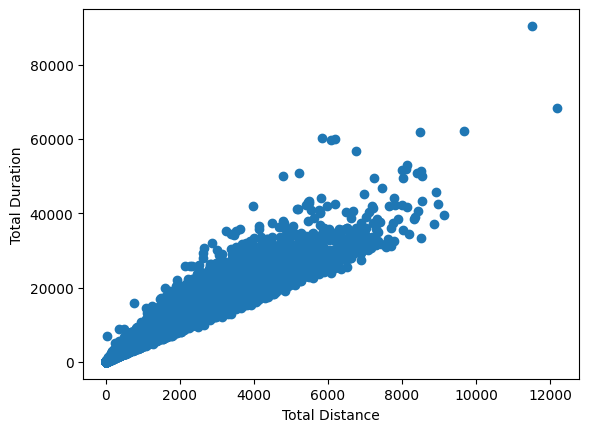

In [91]:
plt.scatter(athlete_df['dist_total'], athlete_df['dur_total'])
plt.xlabel('Total Distance')
plt.ylabel('Total Duration')
plt.show()

In [92]:
pipeline_athlete = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("kmeans", KMeans(n_clusters=4, init="k-means++", random_state=42))
    ]
)

In [93]:
X = athlete_df.drop('athlete', axis=1)

In [94]:
clusters = pipeline_athlete.fit_predict(X)

In [95]:
athlete_df['runner_type'] = clusters

In [96]:
athlete_df['runner_type'].value_counts()

,count
runner_type,
1,12852
0,12137
3,8430
2,2993


In [97]:
k_means_labels = pipeline_athlete.named_steps['kmeans'].labels_
k_means_cluster_centers = pipeline_athlete.named_steps['kmeans'].cluster_centers_

In [98]:
fig = px.scatter(athlete_df, x='dist_total', y='dur_total', color='runner_type', hover_data=['athlete'])
fig.show()

In [99]:
type_map = {
    0: "Marathon Maniac",
    1: "Weekend Warrior",
    2: "Steady Strider",
    3: "Ghost Jogger"
}
athlete_df['runner_label'] = athlete_df['runner_type'].map(type_map)


In [100]:
athlete_df.head()

,athlete,dist_mean,dist_std,dist_total,weeks_active,dur_mean,dur_std,dur_total,runner_type,runner_label
0,0,5.199615,5.794764,270.380000,52,30.266667,34.207331,1573.866667,0,Marathon Maniac
1,1,40.739733,16.782348,2118.466111,52,235.998006,98.757396,12271.896296,3,Ghost Jogger
2,2,9.458077,12.376845,491.820000,52,64.675321,88.036161,3363.116667,1,Weekend Warrior
3,3,72.189812,39.874414,3753.870222,52,314.915420,170.221628,16375.601852,2,Steady Strider
4,4,30.707064,17.446473,1596.767333,52,151.474323,84.396245,7876.664815,1,Weekend Warrior


In [101]:
from sklearn.metrics import silhouette_score

In [103]:
X_scaled = pipeline_athlete.named_steps["scaler"].transform(X)
score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.39


In [106]:
import joblib
joblib.dump(pipeline_athlete, "models/clustering_model.pkl")

['models/clustering_model.pkl']

In [159]:
def calculate_running_gpa(row):
    gpa = 0.0

    # 1. Konsistensi (weeks_active dari 52 minggu)
    if row['weeks_active'] >= 45:
        gpa += 1.2
    elif row['weeks_active'] >= 35:
        gpa += 1.0
    elif row['weeks_active'] >= 20:
        gpa += 0.6
    elif row['weeks_active'] >= 10:
        gpa += 0.3

    # 2. Total jarak lari
    if row['dist_total'] >= 2500:
        gpa += 1.2
    elif row['dist_total'] >= 1500:
        gpa += 1.0
    elif row['dist_total'] >= 800:
        gpa += 0.6
    elif row['dist_total'] >= 200:
        gpa += 0.3

    # 3. Konsistensi jarak (std kecil → konsisten)
    if row['dist_std'] <= 5:
        gpa += 0.8
    elif row['dist_std'] <= 10:
        gpa += 0.6
    elif row['dist_std'] <= 20:
        gpa += 0.3

    # 4. Durasi total lari
    if row['dur_total'] >= 15000:
        gpa += 0.8
    elif row['dur_total'] >= 10000:
        gpa += 0.6
    elif row['dur_total'] >= 5000:
        gpa += 0.3

    return round(min(gpa, 4.0), 2)

def gpa_label(gpa):
    if gpa <= 1.0:
        return "😵 AFK Runner"
    elif gpa <= 2.0:
        return "😴 Jogger Noob"
    elif gpa <= 3.0:
        return "🧢 Casual Cruiser"
    elif gpa <= 3.5:
        return "🏃‍♂️💨 Tryhard Sprinter"
    else:
        return "🔥👑 Legendary Strider"



In [121]:
# 1️⃣ Raw activities (1 atlet) – contoh input Strava mingguan
raw = pd.DataFrame({
    'distance':  [10, 5, 10],      # km per minggu
    'duration':  [500, 350, 650]   # menit per minggu
})

# 2️⃣ Buat fitur agregat yang dibutuhkan model
new_data = pd.DataFrame([{
    'dist_mean'   : raw['distance'].mean(),
    'dist_std'    : raw['distance'].std(ddof=0),   # pakai ddof=0 biar sama kayak std population
    'dist_total'  : raw['distance'].sum(),
    'weeks_active': len(raw),
    'dur_mean'    : raw['duration'].mean(),
    'dur_std'     : raw['duration'].std(ddof=0),
    'dur_total'   : raw['duration'].sum()
}])

# 3️⃣ Inference dengan pipeline (pakai scaler & kmeans yang sama)
X_scaled   = loaded_pipeline.named_steps['scaler'].transform(new_data)
clusters   = loaded_pipeline.named_steps['kmeans'].predict(X_scaled)

new_data['predicted_runner_type']  = clusters
type_map = {0: "Marathon Maniac", 1: "Weekend Warrior",
            2: "Steady Strider",  3: "Ghost Jogger"}
new_data['predicted_runner_label'] = new_data['predicted_runner_type'].map(type_map)

new_data['running_gpa'] = new_data.apply(calculate_running_gpa, axis=1)
new_data['gpa_label'] = new_data['running_gpa'].apply(gpa_label)


new_data


,dist_mean,dist_std,dist_total,weeks_active,dur_mean,dur_std,dur_total,predicted_runner_type,predicted_runner_label,running_gpa,gpa_label
0,8.333333,2.357023,25,3,500.0,122.474487,1500,1,Weekend Warrior,0.8,"😴 KRS Ditolak, Silakan Remedial"


In [160]:
df_strava = pd.read_csv('activities.csv')
df_strava.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Media
0,14317368741,"Apr 28, 2025, 10:44:06 PM",Morning Run,Run,NaN,5203,6.36,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14337931291,"Apr 30, 2025, 10:46:39 PM",Morning Run,Run,NaN,3597,6.15,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,1.973959,NaN,NaN,NaN
2,14359300710,"May 2, 2025, 11:36:22 PM",Morning Run,Run,NaN,2662,4.75,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,1.917356,NaN,NaN,NaN
3,14389691499,"May 5, 2025, 10:57:47 PM",Morning Run,Run,NaN,2365,5.03,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,2.235690,NaN,NaN,NaN
4,14493312052,"May 15, 2025, 10:30:11 PM",Morning Run,Run,NaN,1215,2.40,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,2.177174,NaN,NaN,NaN


In [161]:
df_strava.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 94 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Activity ID                   19 non-null     int64  
 1   Activity Date                 19 non-null     object 
 2   Activity Name                 19 non-null     object 
 3   Activity Type                 19 non-null     object 
 4   Activity Description          0 non-null      float64
 5   Elapsed Time                  19 non-null     int64  
 6   Distance                      19 non-null     float64
 7   Max Heart Rate                0 non-null      float64
 8   Relative Effort               0 non-null      float64
 9   Commute                       19 non-null     bool   
 10  Activity Private Note         0 non-null      float64
 11  Activity Gear                 0 non-null      float64
 12  Filename                      19 non-null     object 
 13  Athlete

In [162]:
df_strava = df_strava.rename(columns={
    "Elapsed Time": "duration_sec",  # total waktu dalam detik
    "Distance": "distance_km",        # dalam meter
    "Activity Date": "date"
})

In [163]:
df_run = df_strava[df_strava['Activity Type'] == 'Run'].copy()
df_run = df_run[(df_run['distance_km'] > 0) & (df_run['duration_sec'] > 0)]

df_run.head()

,Activity ID,date,Activity Name,Activity Type,Activity Description,duration_sec,distance_km,Max Heart Rate,Relative Effort,Commute,...,Activity Count,Total Steps,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Media
0,14317368741,"Apr 28, 2025, 10:44:06 PM",Morning Run,Run,NaN,5203,6.36,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14337931291,"Apr 30, 2025, 10:46:39 PM",Morning Run,Run,NaN,3597,6.15,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,1.973959,NaN,NaN,NaN
2,14359300710,"May 2, 2025, 11:36:22 PM",Morning Run,Run,NaN,2662,4.75,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,1.917356,NaN,NaN,NaN
3,14389691499,"May 5, 2025, 10:57:47 PM",Morning Run,Run,NaN,2365,5.03,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,2.235690,NaN,NaN,NaN
4,14493312052,"May 15, 2025, 10:30:11 PM",Morning Run,Run,NaN,1215,2.40,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,2.177174,NaN,NaN,NaN


In [164]:
df_run['duration_min'] = df_run['duration_sec'] / 60
df_run['date'] = pd.to_datetime(df_run['date'], errors='coerce')
df_run['week'] = df_run['date'].dt.to_period('W').astype(str)

/tmp/ipython-input-164-624638421.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [165]:
df_run.head()

,Activity ID,date,Activity Name,Activity Type,Activity Description,duration_sec,distance_km,Max Heart Rate,Relative Effort,Commute,...,Carbon Saved,Pool Length,Training Load,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Media,duration_min,week
0,14317368741,2025-04-28 22:44:06,Morning Run,Run,NaN,5203,6.36,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.716667,2025-04-28/2025-05-04
1,14337931291,2025-04-30 22:46:39,Morning Run,Run,NaN,3597,6.15,NaN,NaN,False,...,NaN,NaN,NaN,NaN,1.973959,NaN,NaN,NaN,59.950000,2025-04-28/2025-05-04
2,14359300710,2025-05-02 23:36:22,Morning Run,Run,NaN,2662,4.75,NaN,NaN,False,...,NaN,NaN,NaN,NaN,1.917356,NaN,NaN,NaN,44.366667,2025-04-28/2025-05-04
3,14389691499,2025-05-05 22:57:47,Morning Run,Run,NaN,2365,5.03,NaN,NaN,False,...,NaN,NaN,NaN,NaN,2.235690,NaN,NaN,NaN,39.416667,2025-05-05/2025-05-11
4,14493312052,2025-05-15 22:30:11,Morning Run,Run,NaN,1215,2.40,NaN,NaN,False,...,NaN,NaN,NaN,NaN,2.177174,NaN,NaN,NaN,20.250000,2025-05-12/2025-05-18


In [166]:
weekly = df_run.groupby('week').agg({
    'distance_km': 'sum',
    'duration_min': 'sum'
}).reset_index()

user_features = pd.DataFrame([{
    'dist_mean': weekly['distance_km'].mean(),
    'dist_std': weekly['distance_km'].std(ddof=0),
    'dist_total': weekly['distance_km'].sum(),
    'weeks_active': len(weekly),
    'dur_mean': weekly['duration_min'].mean(),
    'dur_std': weekly['duration_min'].std(ddof=0),
    'dur_total': weekly['duration_min'].sum()
}])

In [167]:
user_features

,dist_mean,dist_std,dist_total,weeks_active,dur_mean,dur_std,dur_total
0,7.616364,3.674082,83.78,11,67.456061,43.264149,742.016667


In [168]:
loaded_pipeline = joblib.load("models/clustering_model.pkl")

In [169]:
X_scaled = loaded_pipeline.named_steps['scaler'].transform(user_features)
clusters = loaded_pipeline.named_steps['kmeans'].predict(X_scaled)

type_map = {
    0: "Ghost Jogger",
    1: "Weekend Warrior",
    2: "Steady Strider",
    3: "Marathon Maniac"
}


user_features['runner_type'] = clusters
user_features['runner_label'] = user_features['runner_type'].map(type_map)

user_features['running_gpa'] = user_features.apply(calculate_running_gpa, axis=1)
user_features['gpa_label'] = user_features['running_gpa'].apply(gpa_label)

user_features

,dist_mean,dist_std,dist_total,weeks_active,dur_mean,dur_std,dur_total,runner_type,runner_label,running_gpa,gpa_label
0,7.616364,3.674082,83.78,11,67.456061,43.264149,742.016667,0,Ghost Jogger,1.1,😴 Jogger Noob
